# Testing Snowplow Algorithm

In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autoreload documentation: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

For reloading user modules

Now reload all other modules for updated depot

In [92]:
import Snowplow_Routing_Middleton.dual_graphs as dual_graphs
import Snowplow_Routing_Middleton.construction as construction
import Snowplow_Routing_Middleton.plotting as plotting
import Snowplow_Routing_Middleton.local_search as local_search
import Snowplow_Routing_Middleton.initialize as initialize
import Snowplow_Routing_Middleton.params as params

from Snowplow_Routing_Middleton.shortest_paths import ShortestPaths
from Snowplow_Routing_Middleton.crossover import apply_crossover
from Snowplow_Routing_Middleton.genetic import run_genetic
from Snowplow_Routing_Middleton.solution import Solution
from Snowplow_Routing_Middleton.costs import routes_cost, route_travel_time
from Snowplow_Routing_Middleton.routes_representations import create_full_routes_with_returns
from Snowplow_Routing_Middleton.turns import turn_direction_count

import folium
import osmnx as ox
import networkx as nx
import datetime
import shapely
import numpy as np
import matplotlib.pyplot as plt


In [120]:
approach = "genetic"
instance = "smallstreets"

G = initialize.create_small_streets()
DEPOT = params.find_depot(G)[0]
if approach == "genetic":
    G = initialize.add_multi_edges(G)
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, DEPOT)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G)

elif approach == "annealing":
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, False, True)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G, False, True)



Adding depot source 13


In [121]:
print(G)
print(G_DUAL)

MultiDiGraph with 51 nodes and 139 edges
MultiDiGraph with 140 nodes and 463 edges


In [122]:
sp = ShortestPaths(G_DUAL, False, False)

In [167]:
r, rreq = construction.route_generation(G, sp, DEPOT)
S_first = Solution(rreq, dict(), routes_cost(G, sp, rreq, DEPOT), 0)
print("Old cost:", S_first.cost)

Old cost: 4776.878376036107


Returning home at the end of a route
Returning home at the end of a route
Returning home at the end of a route
{'straight': 96, 'u-turn': 15, 'sharp right': 16, 'right': 14, 'left': 15, 'sharp left': 15}


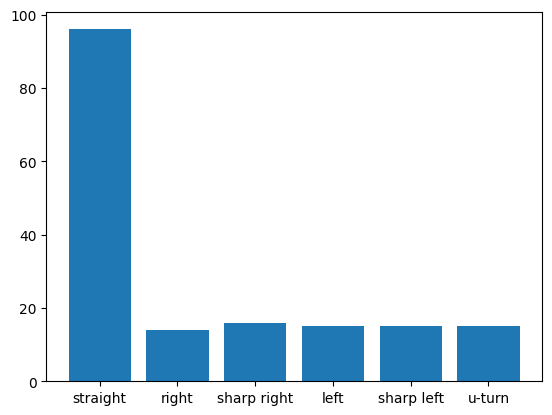

In [124]:
full_routes = create_full_routes_with_returns(G, sp, rreq, DEPOT)
counts, x_axis, y_axis = turn_direction_count(G_DUAL, full_routes)
print(counts)
plt.bar(x_axis, y_axis)
plotting.plot_moving_routes_folium(G, full_routes, label_color="green", path_color="green", m=None)

In [125]:
route_travel_time(G, full_routes, DEPOT)

3773.9973034749814

Test Local Search

In [131]:
required_edges = set(edge[:3] for edge in G.edges(data=True, keys=True) if edge[3]['priority'] != 0)
S_first = Solution(rreq, dict(), routes_cost(G, sp, rreq, DEPOT), 0)
print("Old cost:", S_first.cost)

Old cost: 4574.9809895377475


In [173]:
S_new = local_search.local_improve(S_first, G, sp, required_edges, DEPOT, threshold=1)
print("New cost", S_new.cost)

Modified count:  5
New cost 4604.472714157161


In [187]:
s1, s1req = construction.route_generation(G, sp, DEPOT)
S1 = Solution(s1req, dict(), routes_cost(G, sp, s1req, DEPOT), 0)
S1 = local_search.local_improve(S1, G, sp, required_edges, DEPOT, threshold=1)

s2, s2req = construction.route_generation(G, sp, DEPOT)
S2 = Solution(s2req, dict(), routes_cost(G, sp, s2req, DEPOT), 0)
S2 = local_search.local_improve(S2, G, sp, required_edges, DEPOT, threshold=1)

Modified count:  3
Modified count:  5


In [188]:
routes_new = apply_crossover(G, sp, S1.routes, S2.routes, DEPOT)
routes_cost(G, sp, routes_new, DEPOT)

4574.917574655715

In [192]:
# 4. Route Improvement Algorithms
sol = run_genetic(G, sp, DEPOT)

for route in sol.routes:
    for edge in route:
        print(edge)
    print("***")

initial generation 0
Modified count:  1
initial generation 1
Modified count:  1
initial generation 2
Modified count:  1
initial generation 3
Modified count:  0
initial generation 4
Modified count:  0
initial generation 5
Modified count:  0
initial generation 6
Modified count:  2
initial generation 7
Modified count:  3
initial generation 8
Modified count:  1
initial generation 9
Modified count:  0
Iteration 0
Modified count:  0
Iteration 1
Modified count:  0
Iteration 2
Modified count:  0
Iteration 3
Modified count:  0
Iteration 4
Modified count:  0
Iteration 5
Modified count:  0
Iteration 6
Modified count:  0
Iteration 7
Modified count:  0
Iteration 8
Modified count:  0
Iteration 9
Modified count:  0
Iteration 10
Modified count:  0
Iteration 11
Modified count:  0
Iteration 12
Modified count:  1
Iteration 13
Modified count:  0
Iteration 14
Modified count:  0
Iteration 15
Modified count:  0
Iteration 16
Modified count:  0
Iteration 17
Modified count:  0
Iteration 18
Modified count:  0
It

In [190]:
full_optimized_route = create_full_routes_with_returns(G, sp, sol.routes, DEPOT)
print("Travel time optimized", route_travel_time(G, full_optimized_route, DEPOT))
print("Travel time original", route_travel_time(G, full_routes, DEPOT))
print("Cost optimiazed:", routes_cost(G, sp, sol.routes, DEPOT))
print("Costs origianl:", routes_cost(G, sp, rreq, DEPOT))

Returning home at the end of a route
Travel time optimized 3796.729273768467
Travel time original 3773.9973034749814
Cost optimiazed: 4566.322033809259
Costs origianl: 4776.878376036107


## Plot the routes using Folium

## Algorithm to draw linestrings

1. Have a fixed difference between lat long coords to accept
2. Loop through the coords of the linestring.
    - If the difference is smaller than the desired, continue
    - Otherwise use Numpy to artificially add coords the linestring
3. Add each individual time to individual coords on the linestring so that it is a smooth animation


The reason some of the antipairs are still dashed is because of the construction of the graph. Randomly selected 10% of edges to be not serviced, so some of the corresponding edges in a couple antipairs aren't ever serviced.

In [183]:
original_full_route = create_full_routes_with_returns(G, sp, rreq, DEPOT)
plotting.plot_moving_routes_folium(G, original_full_route, label_color="green", path_color="green", m=None)

Returning home at the end of a route
Returning home at the end of a route
Returning home at the end of a route


In [191]:
new_full_route = create_full_routes_with_returns(G, sp, sol.routes, DEPOT)
plotting.plot_moving_routes_folium(G, new_full_route, label_color="blue", path_color="blue", m=None)

Returning home at the end of a route


Heuristics to implement:
- Go straight as long as possible if its unserviced
- If we hit an unserviced edge at an intersection, we should do everything we can to turn onto that road to service it
- Basically completely prohibit u-turns

Cost function adjustments:
- Rewarding straights and penalizing u-turns
- Penalizing any deadheading (we want to avoid as much as possible!)
